<a href="https://colab.research.google.com/github/jainrasik/NYC-Taxi-Trip-Time-Prediction-Rasik-Jain/blob/main/NYC_Taxi_Trip_Time_Prediction_rasik_jain_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [ ]:
pip install haversine

In [ ]:
# importing all the neccessary libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from datetime import datetime
import math
from statsmodels.stats.outliers_influence import variance_inflation_factor
from geopy.distance import geodesic
from haversine import haversine
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# mounting the drive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Reading the file from drive and converting to Dataframe
dir='/content/drive/MyDrive/Colab Notebooks/Capstone Projects/NYC Taxi Trip Time Prediction-Rasik Jain/'
df=pd.read_csv(dir+'NYC Taxi Data.csv',parse_dates=['pickup_datetime','dropoff_datetime'])

In [ ]:
# checking the data
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
# Checking how many records and features are present in our dataset
df.shape

(1458644, 11)

In [ ]:
# Checking the general Information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


In [ ]:
# Checking are there any NAN values present in our dataset
df.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

#### We have loaded and data and checked how many records and features are present also checked for any NAN values present in our dataset. Then we begin our EDA. Here we see that "id" is insignificant for our analysis so we drop that feature.

In [ ]:
#Dropping the id
df.drop('id',axis=1,inplace=True)

In [ ]:
# checking the data summary
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [ ]:
# assign 'trip_duration' to dependent variable
dependent_variable='trip_duration'

In [ ]:
#checking for correlation
df.corr()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
vendor_id,1.000000,0.287415,0.007820,0.001742,0.001528,0.004496,0.020304
passenger_count,0.287415,1.000000,0.002169,-0.005125,-0.000343,-0.002762,0.008471
pickup_longitude,0.007820,0.002169,1.000000,0.022568,0.783582,0.100190,0.026542
pickup_latitude,0.001742,-0.005125,0.022568,1.000000,0.114884,0.494038,-0.029204
dropoff_longitude,0.001528,-0.000343,0.783582,0.114884,1.000000,0.124873,0.014678
dropoff_latitude,0.004496,-0.002762,0.100190,0.494038,0.124873,1.000000,-0.020677
trip_duration,0.020304,0.008471,0.026542,-0.029204,0.014678,-0.020677,1.000000


Text(0.5, 1.0, 'Distribution plot for trip_duration')

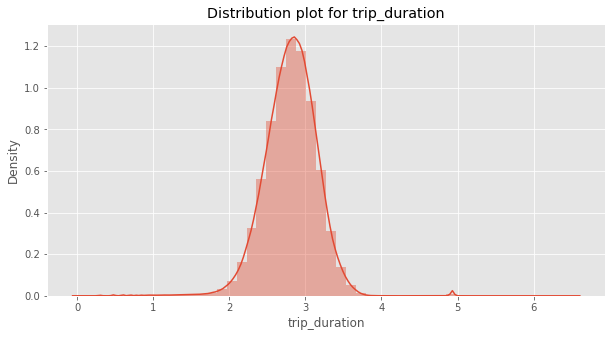

In [ ]:
#Checking the distribution of dependent variable
plt.figure(figsize=[10,5])
plt.style.use('ggplot')
sns.distplot(np.log10(df[dependent_variable]))
plt.title("Distribution plot for trip_duration")

From the above graph we see the distribution is highly positively skewed. there are very few large value present known as oulier which result in this distribution

Text(0, 0.5, 'trip duration')

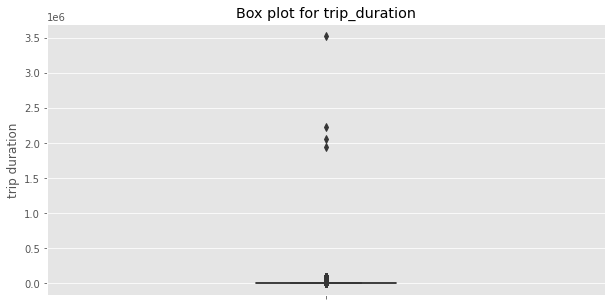

In [ ]:
#checking the outlier present in our dataset.
plt.figure(figsize=[10,5])
sns.boxplot(y='trip_duration',data=df,width=0.25,palette='colorblind')
plt.title("Box plot for trip_duration")
plt.ylabel("trip duration")


from the box plot we see that there are few outlier having very large value. we have to remove those outlier. but first let check that this trip duration has any misentry. To do so we calculate the difference between pick and dropoff time.  

In [ ]:
# creating a function that will out trip duration from pick and dropoff time
def calculate_trip_duration(pickup,dropoff):
    return (dropoff-pickup).total_seconds()

In [ ]:
# creating a feature which stores this calculated trip duration
df['calculate_trip_duration']=df.apply(lambda x: calculate_trip_duration(x['pickup_datetime'],x['dropoff_datetime']),axis=1)

In [ ]:
# checking for any misentry by comparing trip duration with calculated trip duration
(df['calculate_trip_duration']==df['trip_duration']).value_counts()

True    1458644
dtype: int64

here we see that there is no value misentered in trip duration as both calculated and actual trip duration matches. so, this large value are purely an outlier.

In [ ]:
# Dropping the feature created 
df.drop(['calculate_trip_duration'],axis=1,inplace=True)

To checked for outlier we segregate our dependent variable into different categories i.e trip whose duration is less then 1min, within 10mins,within hour,within day, within two day and more than two day

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text major ticklabel objects>)

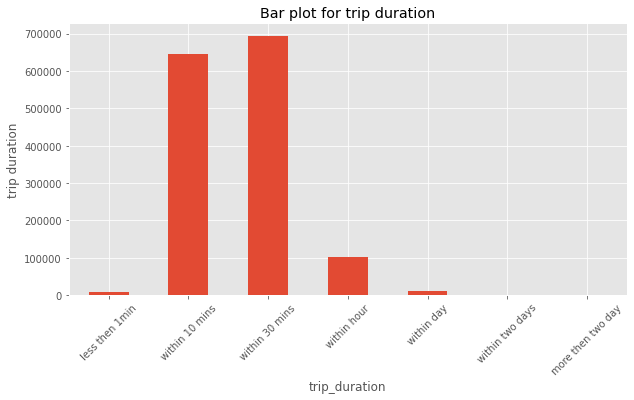

In [ ]:
# segregrating the dependent variable into different categories.
plt.figure(figsize=[10,5])
labels=['less then 1min','within 10 mins','within 30 mins','within hour','within day','within two days','more then two day']
df.groupby(pd.cut(df['trip_duration'],bins=[0,60,600,1800,3600,86400,86400*2,10000000],labels=labels))['trip_duration'].count().plot(kind='bar',fontsize=10)
plt.title("Bar plot for trip duration")
plt.ylabel("trip counts")
plt.ylabel("trip duration")
plt.xticks(rotation=45)

we see that majority of the data lies between 10sec to 1 hour. so we elimate trip duration less then 10 sec and more then 1 hour

In [ ]:
# filtering the data 
df=df[(df['trip_duration']>10)&(df['trip_duration']<3600)]

Text(0.5, 1.0, 'with Transormation')

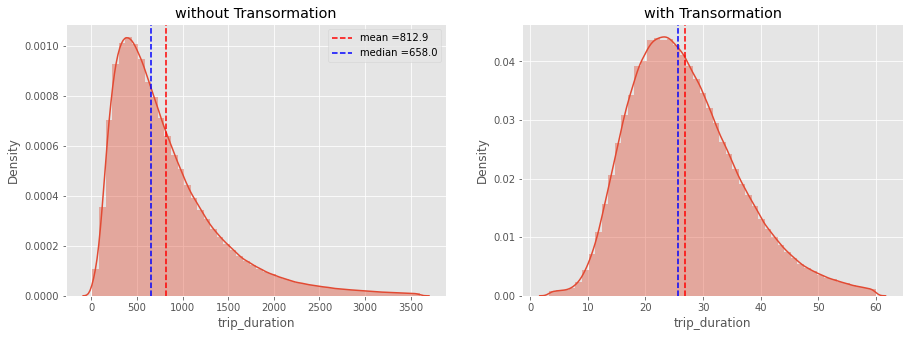

In [ ]:
# checking the distribution of the trip_duration after filtering
fig=plt.figure(figsize=[15,5])
plt.style.use('ggplot')
x=df[dependent_variable]
y=np.sqrt(df[dependent_variable])
plt.subplot(121)
sns.distplot(x)
ax=fig.gca()
ax.axvline(x.mean(),color='red',linestyle='dashed',label='mean ='+str(round(x.mean(),2)))
ax.axvline(x.median(),color='blue',linestyle='dashed',label='median ='+str(round(x.median(),2)))
ax.set_title('without Transormation')
plt.legend(loc='upper right')
plt.subplot(122)
sns.distplot(y)
ax=fig.gca()
ax.axvline(y.mean(),color='red',linestyle='dashed',label='mean ='+str(round(x.median(),2)))
ax.axvline(y.median(),color='blue',linestyle='dashed',label='median ='+str(round(x.median(),2)))
ax.set_title('with Transormation')

In [ ]:
# creating a function to calculate distance based on haversine formula
def hvrsine_dist(x1,x2,y1,y2):
    a=(x1,y1)
    b=(x2,y2)
    return haversine(a,b)

In [ ]:
# Calculating haversine distance
df['hvrdistance']=df.apply(lambda x:  hvrsine_dist(x['pickup_latitude'],x['dropoff_latitude'],x['pickup_longitude'],x['dropoff_longitude']),axis=1)

In [ ]:
# droppping the geographical coordinates
df.drop(['pickup_latitude','dropoff_latitude','pickup_longitude','dropoff_longitude'],axis=1,inplace=True)

In [ ]:
# checking the summary of distance
df.hvrdistance.describe()

count    1.444144e+06
mean     3.341909e+00
std      4.082409e+00
min      0.000000e+00
25%      1.230225e+00
50%      2.081785e+00
75%      3.817294e+00
max      1.240910e+03
Name: hvrdistance, dtype: float64

Text(0, 0.5, 'hvrdistance')

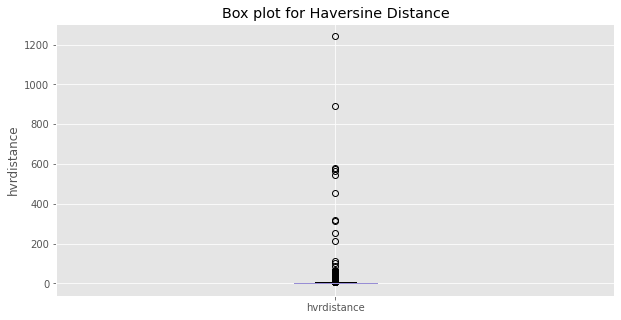

In [ ]:
# checking for outlier present in the data 
plt.figure(figsize=[10,5])
df.hvrdistance.plot(kind='box')
plt.title("Box plot for Haversine Distance")
plt.ylabel("hvrdistance")

(array([0, 1, 2, 3]), <a list of 4 Text major ticklabel objects>)

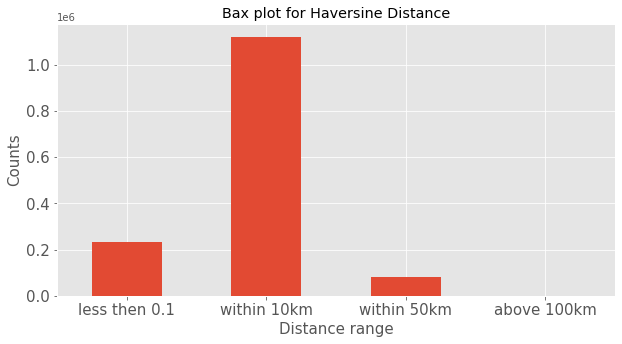

In [ ]:
# segregating the distance variable into different distance ranges
fig=plt.figure(figsize=[10,5])
labels=['less then 0.1','within 10km','within 50km','above 100km']
df.groupby(pd.cut(df.hvrdistance,bins=[0.1,1,10,50,5000],labels=labels))['hvrdistance'].count().plot(kind='bar',fontsize=15)
plt.title("Bax plot for Haversine Distance")
plt.xlabel('Distance range', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.xticks(rotation=0)

Here, we see that a large chunk of the data lies within the 10km distance range. few data are above 50km, so we eliminate the data above 50km distance range.

In [ ]:
# filtering the data 
df=df[df['hvrdistance']<50]

In [ ]:
# Creating month, weekday and hour from pickup datetime variable. 
df['month'] = df.pickup_datetime.dt.month_name()
df['weekday'] = df.pickup_datetime.dt.day_name()
df['pickup_hour'] = df.pickup_datetime.dt.hour

In [ ]:
# droppping the pickup and dropoff date time
df.drop(['pickup_datetime','dropoff_datetime'],axis=1,inplace=True)

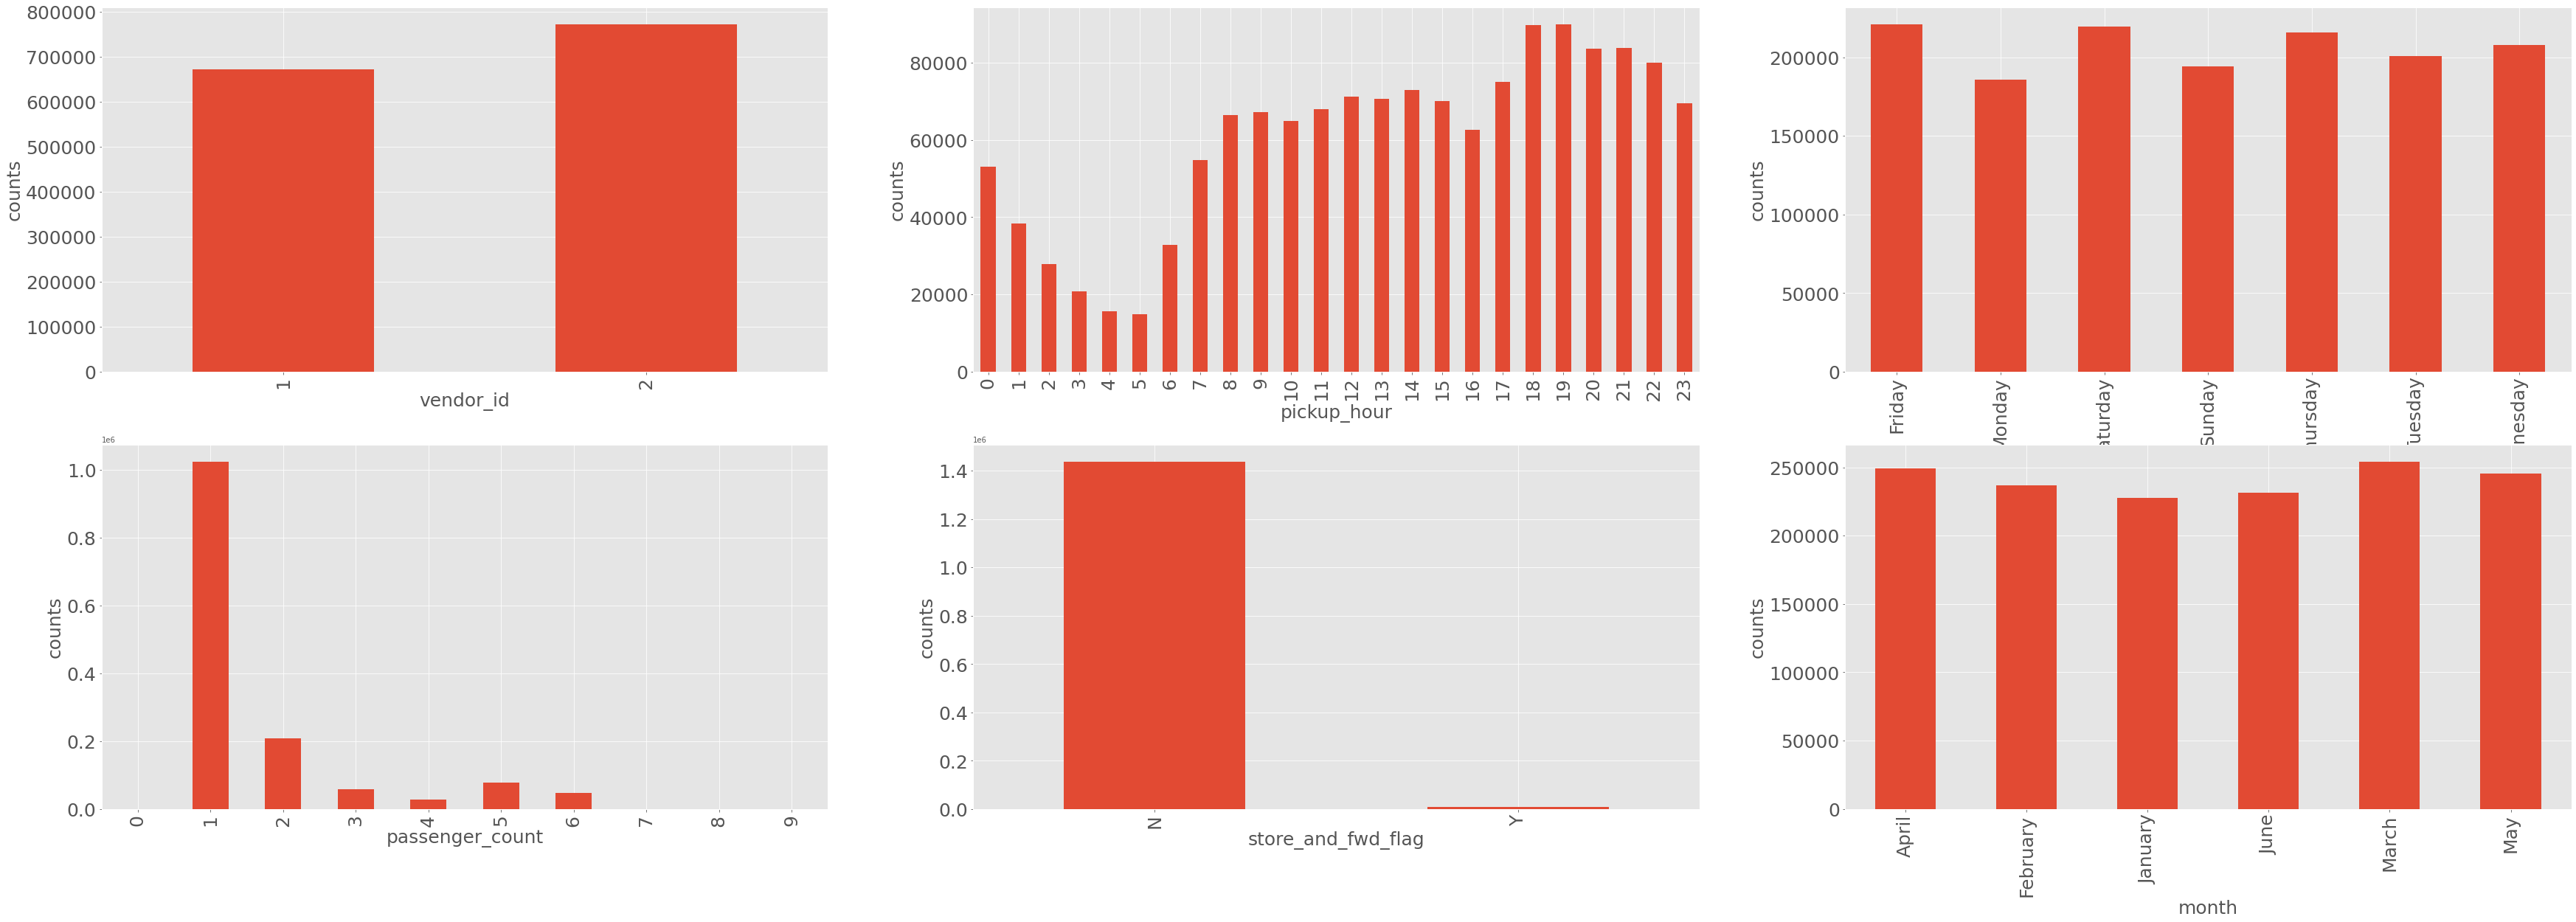

In [ ]:
# Visualizing the categorical variable in our data
categorical_variable=set(df.columns)-{'hvrdistance', 'trip_duration'}
fig=plt.figure(figsize=[60,20])
for i,col in enumerate(categorical_variable):
  plt.subplot(2,3,i+1)
  df.groupby(col)[col].count().plot(kind='bar',fontsize=25)
  plt.xlabel(col, fontsize=25)
  plt.ylabel('counts', fontsize=25)

Here, we see that the feature "store_and_fwd_flag"  has majority of value in N category. thus there is no significans to use this feature. so we drop it from our dataset

In [ ]:
# dropping the feature store_and_fwd_flag
df.drop('store_and_fwd_flag',axis=1,inplace=True)

Here, we see that the feature "passenger count" has value between 0 to 9. Since there is no trip without passenger. we suspect passenger count zero to be a falsy value and removed it from our data set.

In [ ]:
# filtering the data based on passenger_count lower and upper values
df=df[(df['passenger_count']>0)&(df['passenger_count']<7)]

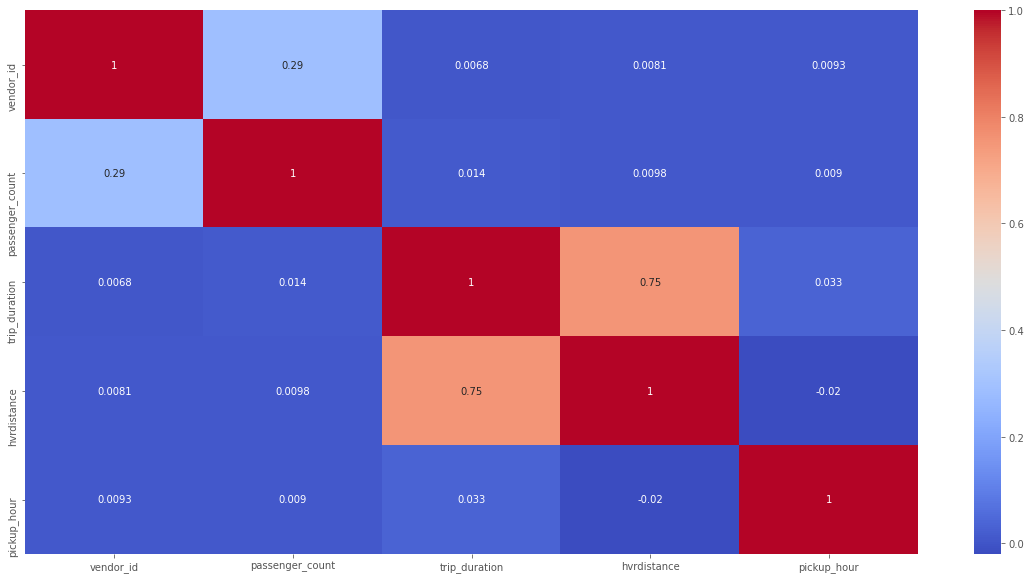

In [ ]:
numerical_variable=df.describe().columns
plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(df[numerical_variable].corr(),annot=True,cmap='coolwarm')


In [ ]:
# function to calculate VIF
def calvif(x):
  vif=pd.DataFrame()
  vif['feature']= x.columns
  vif['vif']=[variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
  return vif

In [ ]:
# Calculating the VIF
independent_numerical_varaible=set(numerical_variable)-{dependent_variable,'dropoff_longitude','dropoff_latitude','vendor_id'}
calvif(df[independent_numerical_varaible])


,feature,vif
0,pickup_hour,2.356023
1,passenger_count,2.100686
2,hvrdistance,1.611980


In [ ]:
# Getting the categorical variable
categorical_variable=set(df.columns)-{'hvrdistance', 'trip_duration'}

In [ ]:
# Creating the dummy varaibles for categorical feature
df=pd.get_dummies(df,columns=categorical_variable)

In [ ]:
df.head()

,trip_duration,hvrdistance,vendor_id_1,vendor_id_2,pickup_hour_0,pickup_hour_1,pickup_hour_2,pickup_hour_3,pickup_hour_4,pickup_hour_5,pickup_hour_6,pickup_hour_7,pickup_hour_8,pickup_hour_9,pickup_hour_10,pickup_hour_11,pickup_hour_12,pickup_hour_13,pickup_hour_14,pickup_hour_15,pickup_hour_16,pickup_hour_17,pickup_hour_18,pickup_hour_19,pickup_hour_20,pickup_hour_21,pickup_hour_22,pickup_hour_23,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,month_April,month_February,month_January,month_June,month_March,month_May
0,455,1.498523,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
1,663,1.805510,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,2124,6.385107,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0
3,429,1.485500,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0
4,435,1.188590,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [ ]:
# making an array for dependent and independent varaible so to pass it to the model
independent_variable=set(df.columns)-{'trip_duration'}
X=df.loc[:,independent_variable].values
y=df.loc[:,'trip_duration'].values

In [ ]:
#Splitting the data into train and test and normalizing the data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)
scaler=MinMaxScaler()
xtrain=scaler.fit_transform(X_train)
xtest=scaler.transform(X_test)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(79250, 46) (79250,)
(19813, 46) (19813,)


In [ ]:
# Applying Linear Regression
regressor=LinearRegression()
regressor.fit(X_train,y_train)
print("Score Train : ", regressor.score(X_train,y_train),"Score Test : ", regressor.score(X_test,y_test))

Score Train :  0.6127608341582675 Score Test :  0.6058259133997943


In [ ]:
def EvaluationMetric(Xt,yt,yp,disp="on"):
  MSE=round(mean_squared_error(y_true=yt,y_pred=yp),2)
  RMSE=round(np.sqrt(MSE),2)
  R2=round(r2_score(y_true=yt,y_pred=yp),4)
  Adjusted_R2=round(1-(1-r2_score(yt, yp))*((Xt.shape[0]-1)/(Xt.shape[0]-Xt.shape[1]-1)),4)
  if disp=="on":
    print("MSE :",MSE,"RMSE :", RMSE)
    print("R2 :",R2,"Adjusted R2 :",Adjusted_R2)
  return(MSE,RMSE,R2,Adjusted_R2)

In [ ]:
def model_eval_comparison_dataframe(model,X_test,X_train,y_train,y_test):
    model_name=[str(model[i]).split('(')[0] for i in range(len(model)) ]
    metric=pd.DataFrame(index=model_name,columns=['MSE(train/test)','RMSE(train/test)','R2(train/test)','Adjusted_R2(train/test)'])
    for i,model in enumerate(model):
      temp_model=model
      temp_model.fit(X_train,y_train)
      y_pred=temp_model.predict(X_train)
      MSE_train,RMSE_train,R2_train,Adjusted_R2_train=EvaluationMetric(X_train,y_train,y_pred,disp='off')
      y_pred=temp_model.predict(X_test)
      MSE_test,RMSE_test,R2_test,Adjusted_R2_test=EvaluationMetric(X_test,y_test,y_pred,disp='off')
      metric.loc[model_name[i],'MSE(train/test)']=str(MSE_train)+"/"+str(MSE_test)
      metric.loc[model_name[i],'RMSE(train/test)']=str(RMSE_train)+"/"+str(RMSE_test)
      metric.loc[model_name[i],'R2(train/test)']=str(R2_train)+"/"+str(R2_test)
      metric.loc[model_name[i],'Adjusted_R2(train/test)']=str(Adjusted_R2_train)+"/"+str(Adjusted_R2_test)
    return metric

Bench marking : Different Regression model

In [ ]:
model=[GradientBoostingRegressor(),AdaBoostRegressor()]
model_eval_comparison_dataframe(model,X_test,X_train,y_train,y_test)

,MSE(train/test),RMSE(train/test),R2(train/test),Adjusted_R2(train/test)
GradientBoostingRegressor,107030.81/107969.39,327.16/328.59,0.6867/0.6806,0.6866/0.6801
AdaBoostRegressor,156948.8/157254.46,396.17/396.55,0.5405/0.5348,0.5405/0.5341


In [ ]:
model=[LinearRegression(),XGBRegressor(),LGBMRegressor()]
model_eval_comparison_dataframe(model,X_test,X_train,y_train,y_test)

[09:12:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,MSE(train/test),RMSE(train/test),R2(train/test),Adjusted_R2(train/test)
LinearRegression,132271.74/133246.0,363.69/365.03,0.6128/0.6058,0.6127/0.6052
XGBRegressor,107030.77/107975.2,327.16/328.6,0.6867/0.6806,0.6866/0.6801
LGBMRegressor,96676.73/98082.92,310.93/313.18,0.717/0.7098,0.717/0.7094


In [ ]:
# Applying XGBoost with hyperparameter tuning
n_estimator=[5,10,20] # No. of tree
max_depth=[5,7,9] # max depth of tree
min_samples_split=[40,50]
params={"n_estimator":n_estimator,"max_depth":max_depth,"min_samples_split":min_samples_split}
xgb=XGBRegressor()
gs_xgb=GridSearchCV(xgb,params,cv=3,scoring='r2')
gs_xgb.fit(X_train,y_train)
print(gs_xgb.best_score_)
print(gs_xgb.best_params_)

[13:40:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:40:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:40:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:40:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:40:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:40:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:41:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:41:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
# predicting from optimal model
gs_xgb_opt=gs_xgb.best_estimator_
y_pred=gs_xgb_opt.predict(X_train)
print('Train')
EvaluationMetric(X_train,y_train,y_pred)
print('Test')
y_pred=gs_xgb_opt.predict(X_test)
EvaluationMetric(X_test,y_test,y_pred)

Train
MSE : 88811.0 RMSE : 298.01
R2 : 0.74 Adjusted R2 : 0.7399
Test
MSE : 103383.76 RMSE : 321.53
R2 : 0.7028 Adjusted R2 : 0.7021


(103383.76, 321.53, 0.7028, 0.7021)

In [ ]:
# Applying LightGBM with hyperparameter tuning
n_estimator=[5,10,20] # No. of tree
max_depth=[5,7,9] # max depth of tree
min_samples_split=[40,50]
params={"n_estimator":n_estimator,"max_depth":max_depth,"min_samples_split":min_samples_split}
lgb=LGBMRegressor()
gs_lgb=GridSearchCV(lgb,params,cv=3,scoring='r2')
gs_lgb.fit(X_train,y_train)
print(gs_lgb.best_score_)
print(gs_lgb.best_params_)

0.7085677950351296
{'max_depth': 9, 'min_samples_split': 40, 'n_estimator': 5}


In [ ]:
# predicting from optimal model
gs_lgb_opt=gs_lgb.best_estimator_
y_pred=gs_lgb_opt.predict(X_train)
print('Train')
EvaluationMetric(X_train,y_train,y_pred)
print('Test')
y_pred=gs_lgb_opt.predict(X_test)
EvaluationMetric(X_test,y_test,y_pred)

Train
MSE : 95187.15 RMSE : 308.52
R2 : 0.7214 Adjusted R2 : 0.7212
Test
MSE : 102844.88 RMSE : 320.69
R2 : 0.7043 Adjusted R2 : 0.7036


(102844.88, 320.69, 0.7043, 0.7036)